# Perkenalan

Nama : Pramudya Adi Nugraha

Batch : 10

Dataset : Disaster Tweets Dataset

Objective :
- Mampu memahami konsep Computer Vision/NLP.
- Mampu mempersiapkan data untuk digunakan dalam model Computer Vision/NLP.
- Mampu mengimplementasikan Artificial Neural Network dengan data yang ada.
- Mampu menganalisis dan menjelaskan layer yang dibuat.

# Import Libraries

In [1]:
!pip install feature-engine

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 260 kB 7.7 MB/s 
     |████████████████████████████████| 9.8 MB 50.8 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder ,StandardScaler, OrdinalEncoder
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
import pickle
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.layers import Embedding, GRU
from keras.layers import Input, Dense, Dropout, GlobalAveragePooling1D,LSTM
from keras import Model, Sequential
from keras.models import load_model
import warnings


# Data Loading

In [3]:
# Load dataset

data = pd.read_csv('tweets.csv')
data

,id,keyword,location,text,target
0,0,ablaze,NaN,"Communal violence in Bhainsa, Telangana. ""Ston...",1
1,1,ablaze,NaN,Telangana: Section 144 has been imposed in Bha...,1
2,2,ablaze,New York City,Arsonist sets cars ablaze at dealership https:...,1
3,3,ablaze,"Morgantown, WV",Arsonist sets cars ablaze at dealership https:...,1
4,4,ablaze,NaN,"""Lord Jesus, your love brings freedom and pard...",0
...,...,...,...,...,...
11365,11365,wrecked,Blue State in a red sea,Media should have warned us well in advance. T...,0
11366,11366,wrecked,arohaonces,i feel directly attacked 💀 i consider moonbin ...,0
11367,11367,wrecked,🇵🇭,i feel directly attacked 💀 i consider moonbin ...,0
11368,11368,wrecked,auroraborealis,"ok who remember ""outcast"" nd the ""dora"" au?? T...",0


In [4]:
# Duplicate dataset

data_copy = data.copy()

In [5]:
# Check dataset info

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11370 entries, 0 to 11369
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        11370 non-null  int64 
 1   keyword   11370 non-null  object
 2   location  7952 non-null   object
 3   text      11370 non-null  object
 4   target    11370 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 444.3+ KB


In [6]:
# Check dataset column

data.columns

Index(['id', 'keyword', 'location', 'text', 'target'], dtype='object')

In [7]:
# Check dataset statistic

data.describe().T

,count,mean,std,min,25%,50%,75%,max
id,11370.0,5684.500000,3282.380615,0.0,2842.25,5684.5,8526.75,11369.0
target,11370.0,0.185928,0.389066,0.0,0.00,0.0,0.00,1.0


In [8]:
data_num_col = data.select_dtypes(include= np.number).columns.tolist()
data_cat_col = data.select_dtypes(include=['object']).columns.tolist()

print('Kolom bertype numeric pada dataset :', data_num_col)
print('Kolom bertype catagorical pada dataset :', data_cat_col)

Kolom bertype numeric pada dataset : ['id', 'target']
Kolom bertype catagorical pada dataset : ['keyword', 'location', 'text']


In [9]:
data[data_cat_col].describe().T

,count,unique,top,freq
keyword,11370,219,thunderstorm,93
location,7952,4504,United States,96
text,11370,11223,I want to help you with my project to save the...,3


# Exploratory Data Analysis (EDA)

In [10]:
# Check dataset shape

data.shape

(11370, 5)

In [11]:
# Looking if theres any missing value in dataset

data.isnull().sum()

id             0
keyword        0
location    3418
text           0
target         0
dtype: int64

Terdapat missing value pada kolom `location`, tetapi tidak akan kita lakukan handling karena kolom ini akan dilakukan drop

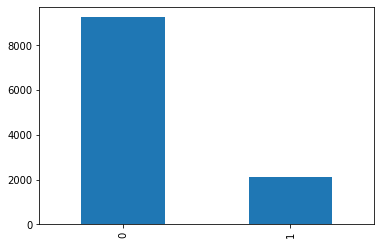

In [12]:
data.target.value_counts().plot(kind= 'bar');

- Dapat dilihat bahwa kolom `target` yang akan dijadikan sebagai target memiliki jumlah yang imbalance, sehingga akan mempengaruhi hasil dari pemodelan
- Pada saat melakukan splitting akan digunakan `stratify` membalance kan antara value yang terdapat

# Data Preprocessing

In [13]:
data

,id,keyword,location,text,target
0,0,ablaze,NaN,"Communal violence in Bhainsa, Telangana. ""Ston...",1
1,1,ablaze,NaN,Telangana: Section 144 has been imposed in Bha...,1
2,2,ablaze,New York City,Arsonist sets cars ablaze at dealership https:...,1
3,3,ablaze,"Morgantown, WV",Arsonist sets cars ablaze at dealership https:...,1
4,4,ablaze,NaN,"""Lord Jesus, your love brings freedom and pard...",0
...,...,...,...,...,...
11365,11365,wrecked,Blue State in a red sea,Media should have warned us well in advance. T...,0
11366,11366,wrecked,arohaonces,i feel directly attacked 💀 i consider moonbin ...,0
11367,11367,wrecked,🇵🇭,i feel directly attacked 💀 i consider moonbin ...,0
11368,11368,wrecked,auroraborealis,"ok who remember ""outcast"" nd the ""dora"" au?? T...",0


Karena kolom yang digunakan untuk melakukan pemodelan untuk memprediksi apakah terjadi bencana atau bukan hanya kolom `text` dan `target`, sehingga kolom `id`, `keyword`, dan `location` akan dilakukan drop

In [14]:
# Drop kolom id, keyword, dan location

data.drop(['id', 'keyword', 'location'],axis = 1, inplace= True)
data

,text,target
0,"Communal violence in Bhainsa, Telangana. ""Ston...",1
1,Telangana: Section 144 has been imposed in Bha...,1
2,Arsonist sets cars ablaze at dealership https:...,1
3,Arsonist sets cars ablaze at dealership https:...,1
4,"""Lord Jesus, your love brings freedom and pard...",0
...,...,...
11365,Media should have warned us well in advance. T...,0
11366,i feel directly attacked 💀 i consider moonbin ...,0
11367,i feel directly attacked 💀 i consider moonbin ...,0
11368,"ok who remember ""outcast"" nd the ""dora"" au?? T...",0


In [15]:
# Get Data for Model Inference

data_inf = data.sample(10, random_state= 18)
data_inf_clear = data_inf.dropna()
data_inf_clear

,text,target
7588,"Another milestone of recovery, another week of...",0
9872,PLS IF Y’ALL DO SOMETHING TOGETHER I’M NOT GON...,0
4821,🌍 | Plan to minimise climate emergency effects...,0
3700,When Phil doesn’t get tips and gets derailed b...,0
3667,"Good morning, there is a derailed freight trai...",1
8865,so interesting to learn that Little Women dire...,0
10420,when you upload your trauma to your 50 differe...,0
3428,A new year’s resolution for architects: never ...,0
11284,"After causing the wreck, they're like..... htt...",0
9139,China sinkhole: Six people killed in Xining as...,1


In [16]:
# Remove Inference-Set from Dataset

data_new = data.drop(data_inf_clear.index)
data_new

,text,target
0,"Communal violence in Bhainsa, Telangana. ""Ston...",1
1,Telangana: Section 144 has been imposed in Bha...,1
2,Arsonist sets cars ablaze at dealership https:...,1
3,Arsonist sets cars ablaze at dealership https:...,1
4,"""Lord Jesus, your love brings freedom and pard...",0
...,...,...
11365,Media should have warned us well in advance. T...,0
11366,i feel directly attacked 💀 i consider moonbin ...,0
11367,i feel directly attacked 💀 i consider moonbin ...,0
11368,"ok who remember ""outcast"" nd the ""dora"" au?? T...",0


In [17]:
# Reset Index

data_new.reset_index(drop=True, inplace=True)
data_inf_clear.reset_index(drop=True, inplace=True)
data_inf_clear

,text,target
0,"Another milestone of recovery, another week of...",0
1,PLS IF Y’ALL DO SOMETHING TOGETHER I’M NOT GON...,0
2,🌍 | Plan to minimise climate emergency effects...,0
3,When Phil doesn’t get tips and gets derailed b...,0
4,"Good morning, there is a derailed freight trai...",1
5,so interesting to learn that Little Women dire...,0
6,when you upload your trauma to your 50 differe...,0
7,A new year’s resolution for architects: never ...,0
8,"After causing the wreck, they're like..... htt...",0
9,China sinkhole: Six people killed in Xining as...,1


## Splitting Dataset

In [18]:
# Split between X (features) and y (target)

X = data_new.drop('target', axis=1)
y = data_new['target']
X

,text
0,"Communal violence in Bhainsa, Telangana. ""Ston..."
1,Telangana: Section 144 has been imposed in Bha...
2,Arsonist sets cars ablaze at dealership https:...
3,Arsonist sets cars ablaze at dealership https:...
4,"""Lord Jesus, your love brings freedom and pard..."
...,...
11355,Media should have warned us well in advance. T...
11356,i feel directly attacked 💀 i consider moonbin ...
11357,i feel directly attacked 💀 i consider moonbin ...
11358,"ok who remember ""outcast"" nd the ""dora"" au?? T..."


In [19]:
y

0        1
1        1
2        1
3        1
4        0
        ..
11355    0
11356    0
11357    0
11358    0
11359    1
Name: target, Length: 11360, dtype: int64

In [20]:
# Split between Train-Set and Test-Set


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=18, stratify= data_new.target)

print('X Train Size : ', X_train.shape)
print('X Test Size  : ', X_test.shape)
print('y Train Size : ', y_train.shape)
print('y Test Size  : ', y_test.shape)

X Train Size :  (9088, 1)
X Test Size  :  (2272, 1)
y Train Size :  (9088,)
y Test Size  :  (2272,)


In [21]:
# Split between Train-Set and Val-Set


X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=18, stratify= y_train)

print('X Train Size : ', X_train.shape)
print('X val Size  : ', X_val.shape)
print('y Train Size : ', y_train.shape)
print('y val Size  : ', y_val.shape)

X Train Size :  (8179, 1)
X val Size  :  (909, 1)
y Train Size :  (8179,)
y val Size  :  (909,)


---
## Feature Encoding

In [22]:
# siapkan label

y_train_ohe = to_categorical(y_train)
y_val_ohe = to_categorical(y_val)
y_test_ohe = to_categorical(y_test)

In [73]:
# setup vect
max_vocab_length = 1000
max_length = 150

text_vectorization = TextVectorization(max_tokens= max_vocab_length,
                                       standardize= 'lower_and_strip_punctuation',
                                       split= 'whitespace',
                                       ngrams= None,
                                       output_mode= 'int',
                                       output_sequence_length= max_length,
                                       input_shape =(1,))

In [74]:
text_vectorization.adapt(X_train)

In [75]:
# embedding layer

embedding = Embedding(input_dim=max_vocab_length,
                      output_dim=128,
                      embeddings_initializer="uniform",
                      input_length=max_length
                      )

# Model Definition

## Functional API

In [76]:
X_train.shape

(8179, 1)

In [77]:
# Deklarasikan arsitektur 

inputs = Input(shape=(1,), dtype="string")
x = text_vectorization(inputs)
x = embedding(x)
x = GlobalAveragePooling1D()(x)
x = Dropout(0.5)(x)
x = Dense(32, activation='relu')(x)
x = Dropout(0.4)(x)
out = Dense(2, activation='softmax')(x)
model = Model(inputs, out)

# Summarize layers

print(model.summary())

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 150)              0         
 ectorization)                                                   
                                                                 
 embedding_1 (Embedding)     (None, 150, 128)          128000    
                                                                 
 global_average_pooling1d_4   (None, 128)              0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dropout_9 (Dropout)         (None, 128)               0         
                                                                 
 dense_12 (Dense)            (None, 32)                4128

In [78]:
# Compile

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [79]:
# Training

history = model.fit(X_train,
                         y_train_ohe,
                         epochs=50,
                         validation_data=(X_val, y_val_ohe))

Epoch 1/50
256/256 [==============================] - 3s 7ms/step - loss: 0.4948 - accuracy: 0.8138 - val_loss: 0.4706 - val_accuracy: 0.8141
Epoch 2/50
256/256 [==============================] - 2s 6ms/step - loss: 0.4686 - accuracy: 0.8140 - val_loss: 0.4510 - val_accuracy: 0.8141
Epoch 3/50
256/256 [==============================] - 2s 6ms/step - loss: 0.4216 - accuracy: 0.8165 - val_loss: 0.3857 - val_accuracy: 0.8163
Epoch 4/50
256/256 [==============================] - 2s 6ms/step - loss: 0.3620 - accuracy: 0.8480 - val_loss: 0.3491 - val_accuracy: 0.8713
Epoch 5/50
256/256 [==============================] - 2s 7ms/step - loss: 0.3172 - accuracy: 0.8799 - val_loss: 0.3243 - val_accuracy: 0.8713
Epoch 6/50
256/256 [==============================] - 1s 6ms/step - loss: 0.2958 - accuracy: 0.8868 - val_loss: 0.3215 - val_accuracy: 0.8757
Epoch 7/50
256/256 [==============================] - 1s 6ms/step - loss: 0.2890 - accuracy: 0.8886 - val_loss: 0.3344 - val_accuracy: 0.8746
Epoch 

In [80]:
metrics = pd.DataFrame(history.history)
metrics.head()

,loss,accuracy,val_loss,val_accuracy
0,0.494762,0.813791,0.470602,0.814081
1,0.468610,0.814036,0.450992,0.814081
2,0.421619,0.816481,0.385681,0.816282
3,0.361960,0.848025,0.349085,0.871287
4,0.317164,0.879936,0.324260,0.871287


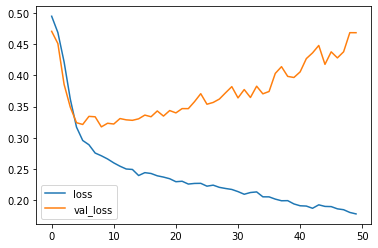

In [81]:
metrics[['loss', 'val_loss']].plot();

In [82]:
# Evaluate model using classification report

y_pred = model.predict(X_val)
y_pred = y_pred.argmax(axis=1)
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.94      0.93       740
           1       0.70      0.59      0.64       169

    accuracy                           0.88       909
   macro avg       0.81      0.76      0.78       909
weighted avg       0.87      0.88      0.87       909



## Sequential API

In [33]:
X_train.shape

(8179, 1)

In [83]:
# Deklarasikan arsitektur 

model_2 = Sequential()
model_2.add(text_vectorization)
model_2.add(embedding)
model_2.add(GlobalAveragePooling1D())
model_2.add(Dropout(0.5))
model_2.add(Dense(32, activation='relu'))
model_2.add(Dropout(0.4))
model_2.add(Dense(2, activation='softmax'))

# Summarize model_2

print(model_2.summary())

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_1 (TextV  (None, 150)              0         
 ectorization)                                                   
                                                                 
 embedding_1 (Embedding)     (None, 150, 128)          128000    
                                                                 
 global_average_pooling1d_5   (None, 128)              0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dropout_11 (Dropout)        (None, 128)               0         
                                                                 
 dense_14 (Dense)            (None, 32)                4128      
                                                                 
 dropout_12 (Dropout)        (None, 32)               

In [84]:
# Compile

model_2.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# Training

history_2 = model_2.fit(X_train,
                         y_train_ohe,
                         epochs=50,
                         validation_data=(X_val, y_val_ohe))

Epoch 1/50
256/256 [==============================] - 2s 7ms/step - loss: 0.4128 - accuracy: 0.8242 - val_loss: 0.3426 - val_accuracy: 0.8570
Epoch 2/50
256/256 [==============================] - 2s 6ms/step - loss: 0.2749 - accuracy: 0.8891 - val_loss: 0.3318 - val_accuracy: 0.8867
Epoch 3/50
256/256 [==============================] - 2s 6ms/step - loss: 0.2443 - accuracy: 0.9071 - val_loss: 0.3347 - val_accuracy: 0.8779
Epoch 4/50
256/256 [==============================] - 2s 6ms/step - loss: 0.2302 - accuracy: 0.9118 - val_loss: 0.3375 - val_accuracy: 0.8790
Epoch 5/50
256/256 [==============================] - 2s 9ms/step - loss: 0.2236 - accuracy: 0.9166 - val_loss: 0.3484 - val_accuracy: 0.8768
Epoch 6/50
256/256 [==============================] - 2s 7ms/step - loss: 0.2208 - accuracy: 0.9159 - val_loss: 0.3534 - val_accuracy: 0.8768
Epoch 7/50
256/256 [==============================] - 2s 7ms/step - loss: 0.2129 - accuracy: 0.9205 - val_loss: 0.3628 - val_accuracy: 0.8801
Epoch 

In [85]:
metrics_2 = pd.DataFrame(history_2.history)
metrics_2.head()

,loss,accuracy,val_loss,val_accuracy
0,0.412839,0.824184,0.342587,0.856986
1,0.274902,0.889106,0.331827,0.886689
2,0.244256,0.907079,0.334729,0.877888
3,0.230210,0.911847,0.337549,0.878988
4,0.223554,0.916616,0.348351,0.876788


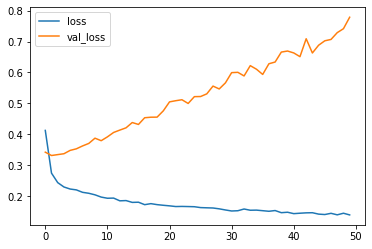

In [86]:
metrics_2[['loss', 'val_loss']].plot();

In [87]:
y_pred_2 = model_2.predict(X_val)
y_pred_2 = y_pred_2.argmax(axis=1)
print(classification_report(y_val, y_pred_2))

              precision    recall  f1-score   support

           0       0.91      0.95      0.93       740
           1       0.73      0.57      0.64       169

    accuracy                           0.88       909
   macro avg       0.82      0.76      0.78       909
weighted avg       0.87      0.88      0.87       909



## LSTM

In [88]:
# Deklarasikan arsitektur 

model_3 = Sequential()
model_3.add(text_vectorization)
model_3.add(embedding)
model_3.add(Dropout(0.5))
model_3.add(LSTM(32))
model_3.add(Dropout(0.4))
model_3.add(Dense(2, activation='softmax'))

# Summarize model_3

print(model_3.summary())

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_1 (TextV  (None, 150)              0         
 ectorization)                                                   
                                                                 
 embedding_1 (Embedding)     (None, 150, 128)          128000    
                                                                 
 dropout_13 (Dropout)        (None, 150, 128)          0         
                                                                 
 lstm_2 (LSTM)               (None, 32)                20608     
                                                                 
 dropout_14 (Dropout)        (None, 32)                0         
                                                                 
 dense_16 (Dense)            (None, 2)                 66        
                                                      

In [89]:
# Compile

model_3.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# Training

history_3 = model_3.fit(X_train,
                         y_train_ohe,
                         epochs=50,
                         validation_data=(X_val, y_val_ohe))

Epoch 1/50
256/256 [==============================] - 25s 89ms/step - loss: 0.4945 - accuracy: 0.8129 - val_loss: 0.4810 - val_accuracy: 0.8141
Epoch 2/50
256/256 [==============================] - 22s 87ms/step - loss: 0.4868 - accuracy: 0.8140 - val_loss: 0.4814 - val_accuracy: 0.8141
Epoch 3/50
256/256 [==============================] - 22s 86ms/step - loss: 0.4868 - accuracy: 0.8140 - val_loss: 0.4814 - val_accuracy: 0.8141
Epoch 4/50
256/256 [==============================] - 23s 89ms/step - loss: 0.4857 - accuracy: 0.8140 - val_loss: 0.4809 - val_accuracy: 0.8141
Epoch 5/50
256/256 [==============================] - 23s 88ms/step - loss: 0.4840 - accuracy: 0.8140 - val_loss: 0.4807 - val_accuracy: 0.8141
Epoch 6/50
256/256 [==============================] - 22s 84ms/step - loss: 0.4836 - accuracy: 0.8140 - val_loss: 0.4804 - val_accuracy: 0.8141
Epoch 7/50
256/256 [==============================] - 22s 85ms/step - loss: 0.4831 - accuracy: 0.8140 - val_loss: 0.4803 - val_accuracy:

In [90]:
metrics_3 = pd.DataFrame(history_3.history)
metrics_3.head()

,loss,accuracy,val_loss,val_accuracy
0,0.494517,0.812936,0.480970,0.814081
1,0.486779,0.814036,0.481426,0.814081
2,0.486755,0.814036,0.481431,0.814081
3,0.485716,0.814036,0.480855,0.814081
4,0.484032,0.814036,0.480674,0.814081


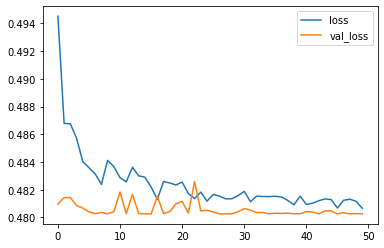

In [91]:
metrics_3[['loss', 'val_loss']].plot();

In [92]:
y_pred_3 = model_3.predict(X_val)
y_pred_3 = y_pred_3.argmax(axis=1)
print(classification_report(y_val, y_pred_3))

              precision    recall  f1-score   support

           0       0.81      1.00      0.90       740
           1       0.00      0.00      0.00       169

    accuracy                           0.81       909
   macro avg       0.41      0.50      0.45       909
weighted avg       0.66      0.81      0.73       909



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## GRU

In [93]:
# Deklarasikan arsitektur 

model_4 = Sequential()
model_4.add(text_vectorization)
model_4.add(embedding)
model_4.add(Dropout(0.5))
model_4.add(GRU(32))
model_4.add(Dropout(0.4))
model_4.add(Dense(2, activation='softmax'))

# Summarize model_4

print(model_4.summary())

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_1 (TextV  (None, 150)              0         
 ectorization)                                                   
                                                                 
 embedding_1 (Embedding)     (None, 150, 128)          128000    
                                                                 
 dropout_15 (Dropout)        (None, 150, 128)          0         
                                                                 
 gru_2 (GRU)                 (None, 32)                15552     
                                                                 
 dropout_16 (Dropout)        (None, 32)                0         
                                                                 
 dense_17 (Dense)            (None, 2)                 66        
                                                      

In [94]:
# Compile

model_4.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# Training

history_4 = model_4.fit(X_train,
                         y_train_ohe,
                         epochs=50,
                         validation_data=(X_val, y_val_ohe))

Epoch 1/50
256/256 [==============================] - 26s 88ms/step - loss: 0.4936 - accuracy: 0.8126 - val_loss: 0.4807 - val_accuracy: 0.8141
Epoch 2/50
256/256 [==============================] - 22s 85ms/step - loss: 0.4857 - accuracy: 0.8140 - val_loss: 0.4807 - val_accuracy: 0.8141
Epoch 3/50
256/256 [==============================] - 22s 86ms/step - loss: 0.4847 - accuracy: 0.8140 - val_loss: 0.4829 - val_accuracy: 0.8141
Epoch 4/50
256/256 [==============================] - 22s 85ms/step - loss: 0.4873 - accuracy: 0.8140 - val_loss: 0.4804 - val_accuracy: 0.8141
Epoch 5/50
256/256 [==============================] - 22s 86ms/step - loss: 0.4850 - accuracy: 0.8140 - val_loss: 0.4803 - val_accuracy: 0.8141
Epoch 6/50
256/256 [==============================] - 22s 87ms/step - loss: 0.4853 - accuracy: 0.8140 - val_loss: 0.4849 - val_accuracy: 0.8141
Epoch 7/50
256/256 [==============================] - 22s 87ms/step - loss: 0.4857 - accuracy: 0.8140 - val_loss: 0.4803 - val_accuracy:

In [95]:
metrics_4 = pd.DataFrame(history_4.history)
metrics_4.head()

,loss,accuracy,val_loss,val_accuracy
0,0.493568,0.812569,0.480725,0.814081
1,0.485685,0.814036,0.480685,0.814081
2,0.484712,0.814036,0.482914,0.814081
3,0.487320,0.814036,0.480426,0.814081
4,0.485046,0.814036,0.480251,0.814081


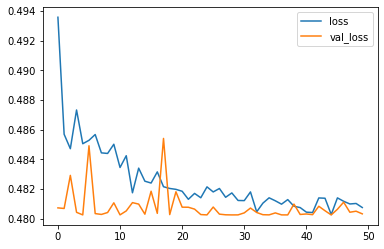

In [96]:
metrics_4[['loss', 'val_loss']].plot();

In [97]:
y_pred_4 = model_4.predict(X_val)
y_pred_4 = y_pred_4.argmax(axis=1)
print(classification_report(y_val, y_pred_4))

              precision    recall  f1-score   support

           0       0.81      1.00      0.90       740
           1       0.00      0.00      0.00       169

    accuracy                           0.81       909
   macro avg       0.41      0.50      0.45       909
weighted avg       0.66      0.81      0.73       909



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


- Dari semua pemodelan yang sudah dilakukan diketahui bahwa didapatkan hasil yang overfit, sehingga akan dipilih pemodelan yang memiliki akurasi tertinggi dan nilai precision tertinggi juga
- Didapati bahwa pemodelan dengan Sequential API memiliki nilai akurasi tertinggi dan nilai precision tertinggi juga

# Making Pipeline

## Pipeline for Sequential API

In [100]:
#Train Dataset

X_train_pipe_seq = tf.data.Dataset.from_tensor_slices((X_train, y_train_ohe))
X_train_pipe_seq = X_train_pipe_seq.batch(50)

#Test Dataset

X_test_pipe_seq = tf.data.Dataset.from_tensor_slices((X_test, y_test_ohe))
X_test_pipe_seq = X_test_pipe_seq.batch(50)

#Validation Dataset

X_val_pipe_seq = tf.data.Dataset.from_tensor_slices((X_val, y_val_ohe))
X_val_pipe_seq = X_val_pipe_seq.batch(50)

#Call Model

model_pipe = Sequential()
model_pipe.add(text_vectorization)
model_pipe.add(embedding)
model_pipe.add(GlobalAveragePooling1D())
model_pipe.add(Dropout(0.5))
model_pipe.add(Dense(32, activation='relu'))
model_pipe.add(Dropout(0.4))
model_pipe.add(Dense(2, activation='softmax'))
model_pipe.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

#Fit

history_pipe = model_pipe.fit(X_train_pipe_seq, epochs=50, validation_data=X_val_pipe_seq)

Epoch 1/50
164/164 [==============================] - 5s 14ms/step - loss: 0.3860 - accuracy: 0.8347 - val_loss: 0.3341 - val_accuracy: 0.8768
Epoch 2/50
164/164 [==============================] - 2s 11ms/step - loss: 0.2605 - accuracy: 0.8960 - val_loss: 0.3399 - val_accuracy: 0.8790
Epoch 3/50
164/164 [==============================] - 2s 13ms/step - loss: 0.2367 - accuracy: 0.9131 - val_loss: 0.3487 - val_accuracy: 0.8713
Epoch 4/50
164/164 [==============================] - 1s 7ms/step - loss: 0.2241 - accuracy: 0.9149 - val_loss: 0.3539 - val_accuracy: 0.8735
Epoch 5/50
164/164 [==============================] - 1s 7ms/step - loss: 0.2114 - accuracy: 0.9196 - val_loss: 0.3648 - val_accuracy: 0.8713
Epoch 6/50
164/164 [==============================] - 1s 7ms/step - loss: 0.1987 - accuracy: 0.9233 - val_loss: 0.3803 - val_accuracy: 0.8735
Epoch 7/50
164/164 [==============================] - 1s 7ms/step - loss: 0.1911 - accuracy: 0.9298 - val_loss: 0.3984 - val_accuracy: 0.8801
Epo

In [103]:
model_pipe.save('disaster_model', save_format= 'tf')

INFO:tensorflow:Assets written to: disaster_model/assets


# Model Inference

In [108]:
new_tweet = [
            "Seven people killed in a bomb acciednt",
            "i accidently falling in love with you",
            "there is a thypon near here"
]

hasil = model_pipe.predict(new_tweet)
hasil.argmax(axis=1)

array([0, 0, 0])

# Pengambilan Kesimpulan

- Dataset yang digunakan memiliki persentase yang tidak seimbang pada kolom target. Dengan nilai 0 : 9.256 dan nilai 1 : 2.114
- Pemodelan yang akan ditarining yaitu Funtional API, Sequential API, LTSM, dan GRU
- Dari hasil training pemodelan didapatkan semua pemodelan memiliki hasil yang ovefit ini dapat disebabkan karena data yang digunakan terlalu sedikit
- Dari semua pemodelan yang memiliki nilai akurasi terbesar dan nilai precision terbesar ada Sequential API, sehingga pemodelan ini yang akan digunakan untuk deployment